<a href="https://colab.research.google.com/github/MehrdadJalali-AI/BlackHole/blob/main/sparsification_analysis_fixed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

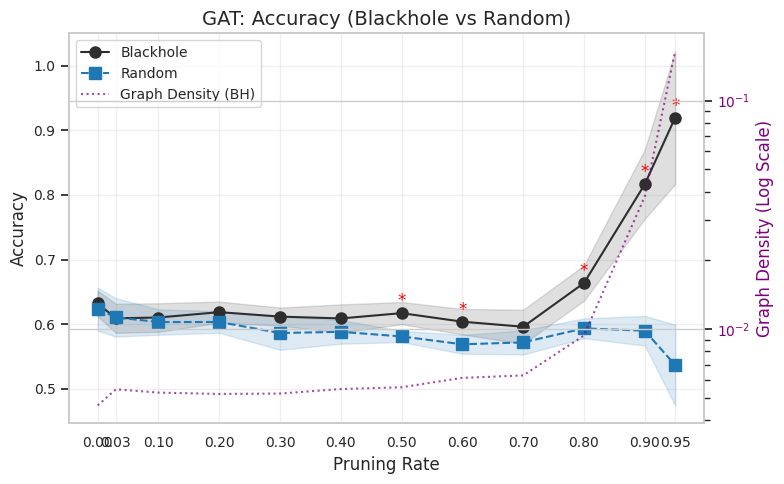

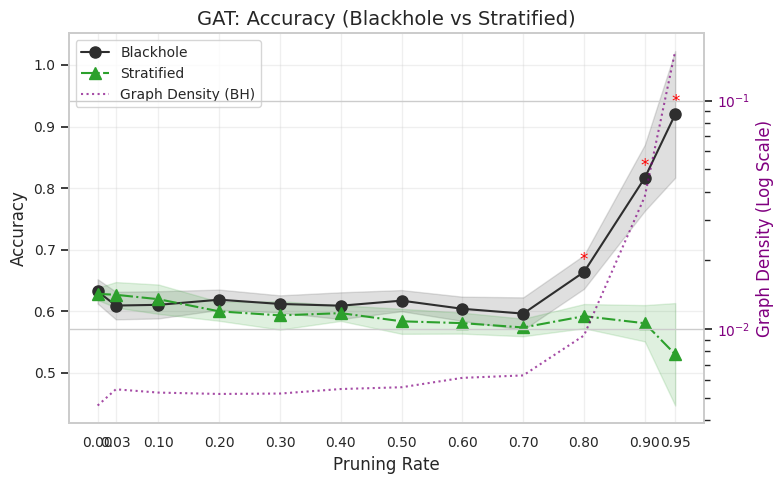

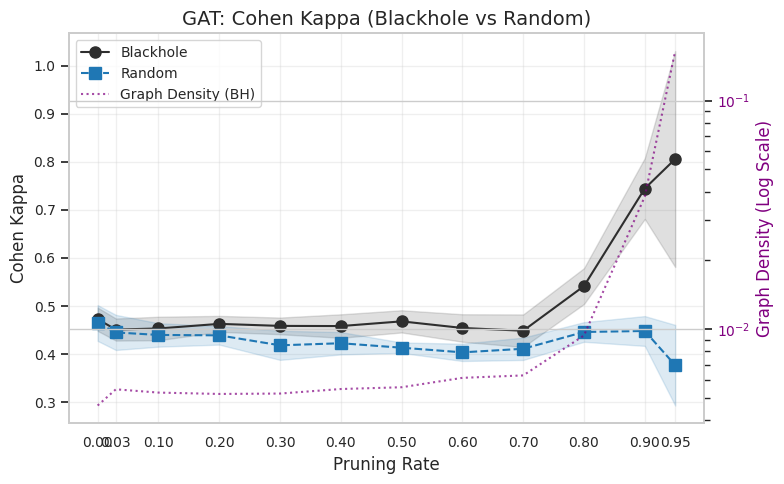

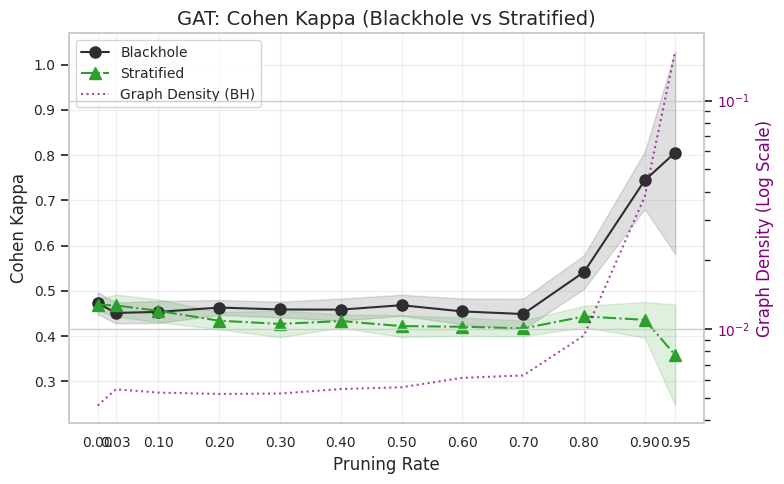

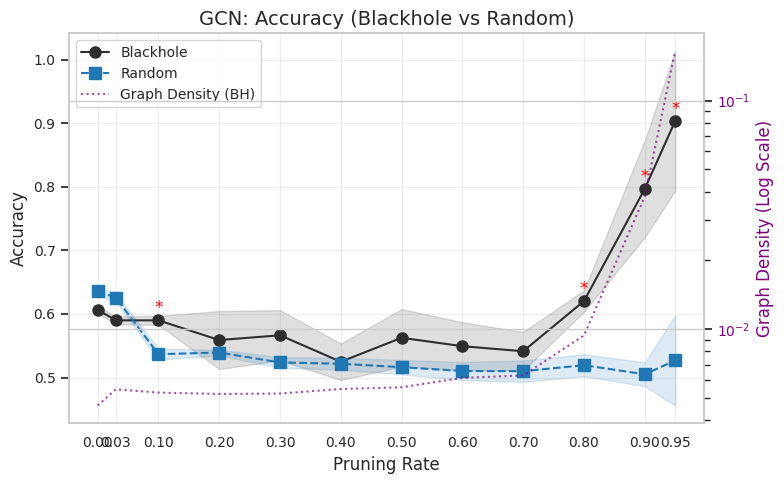

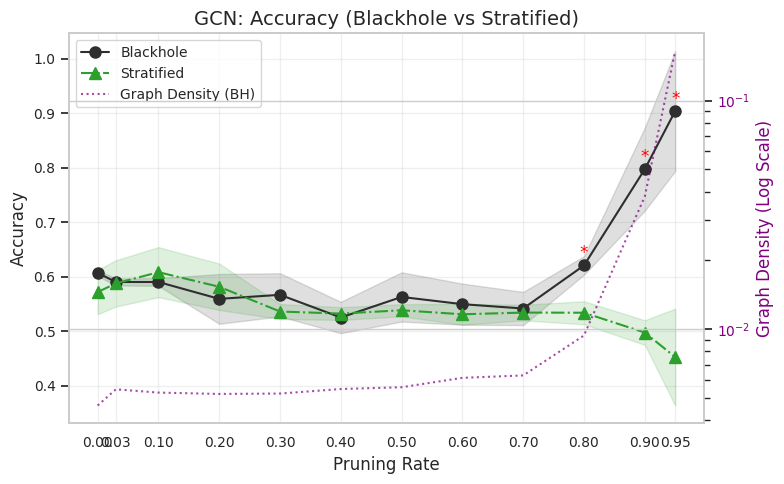

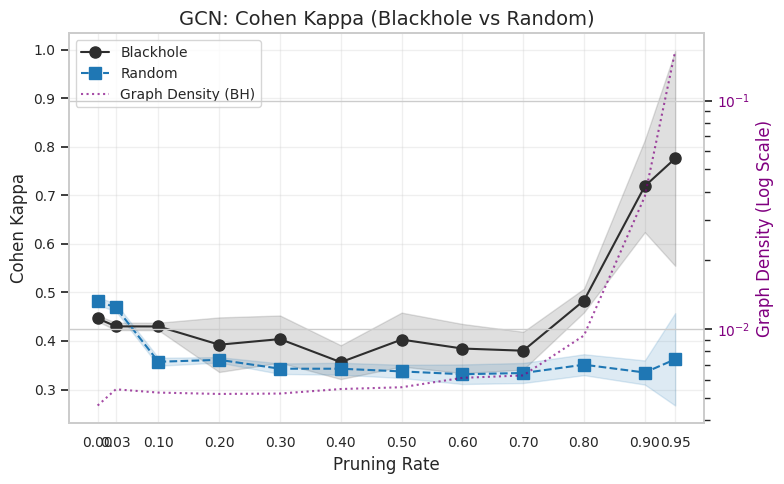

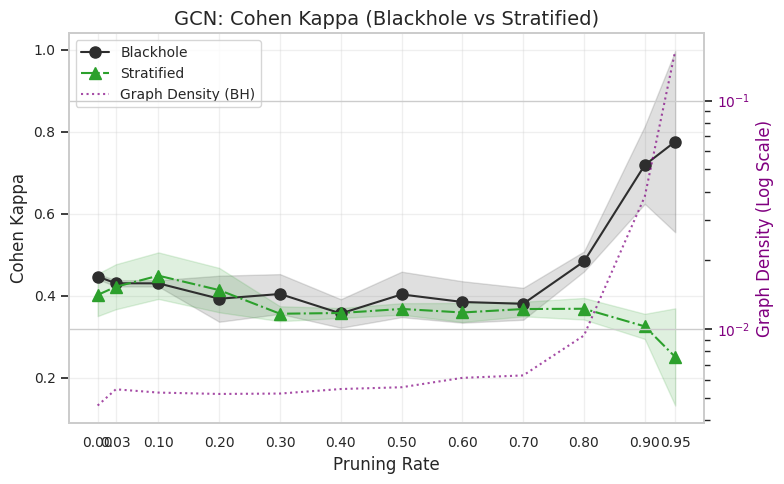

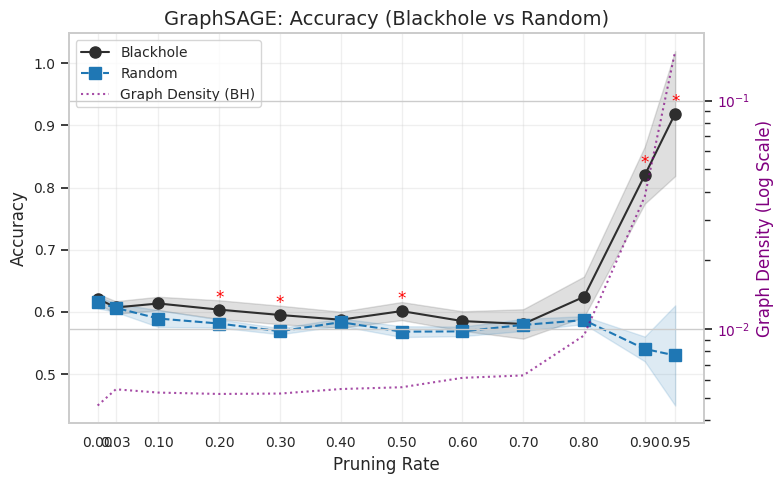

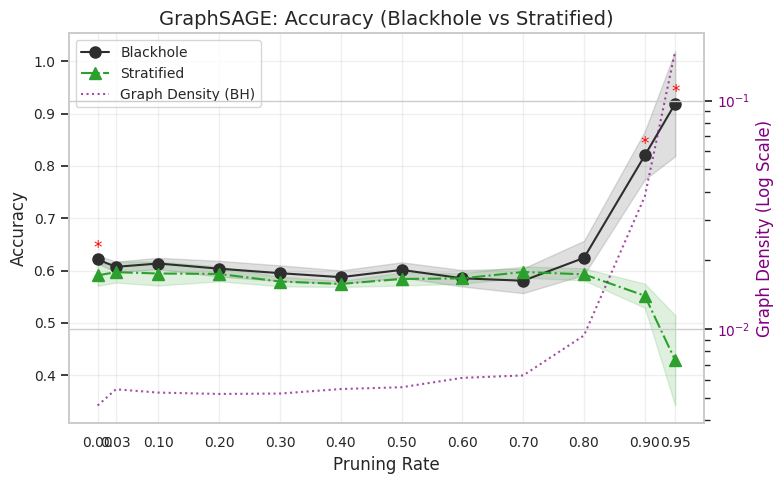

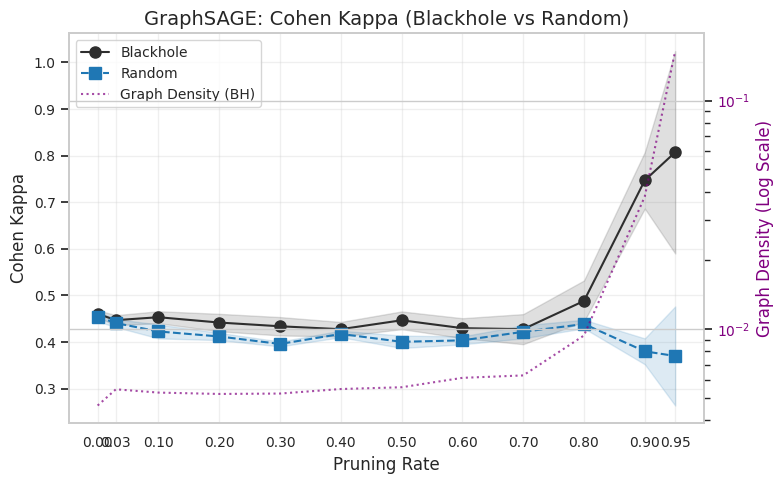

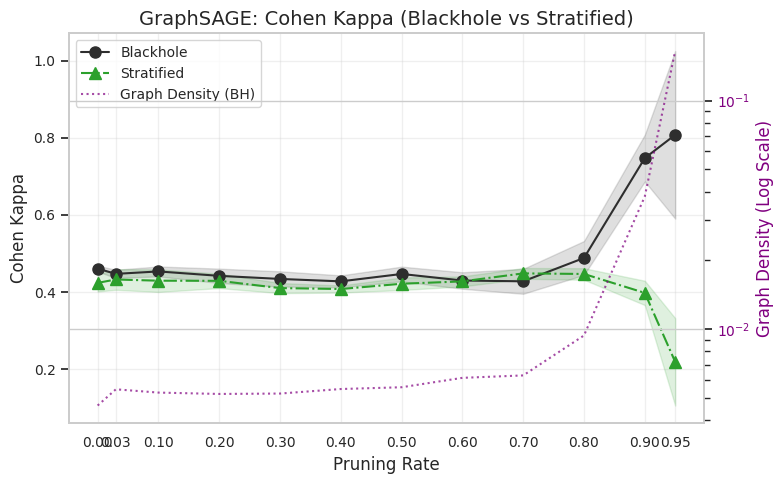

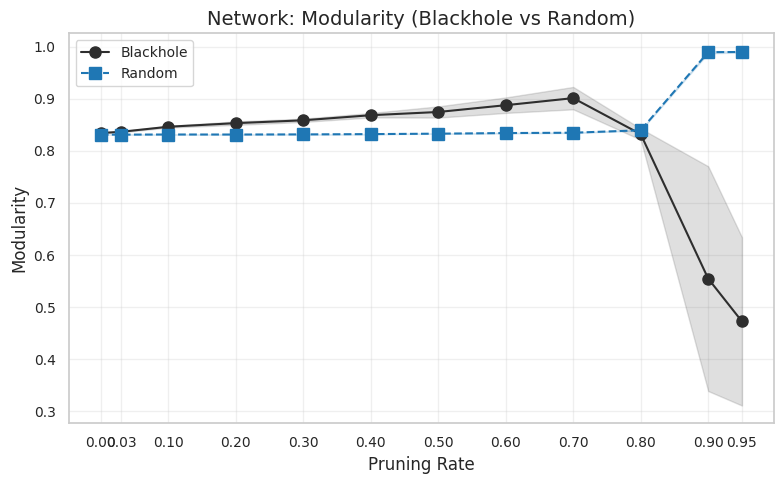

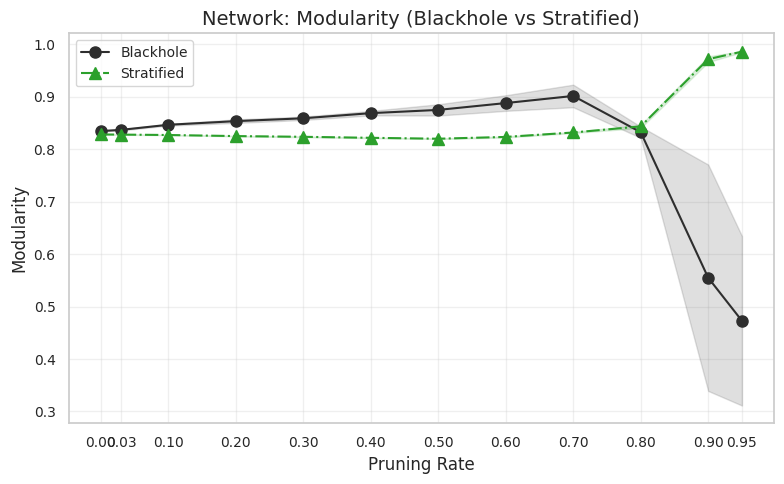

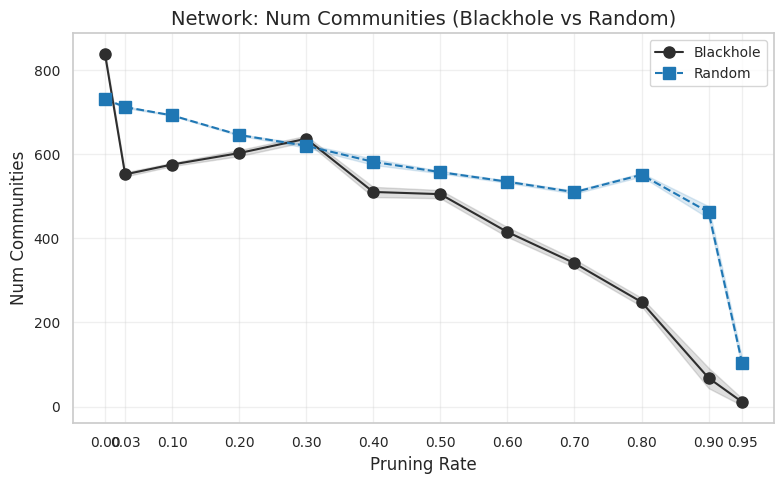

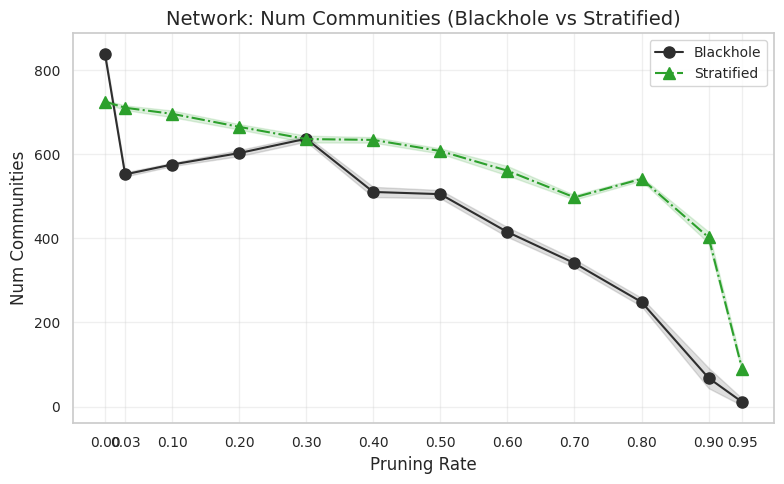

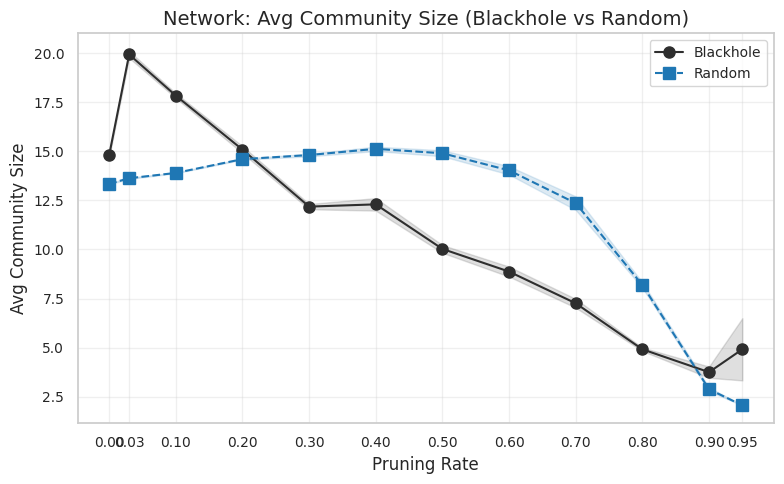

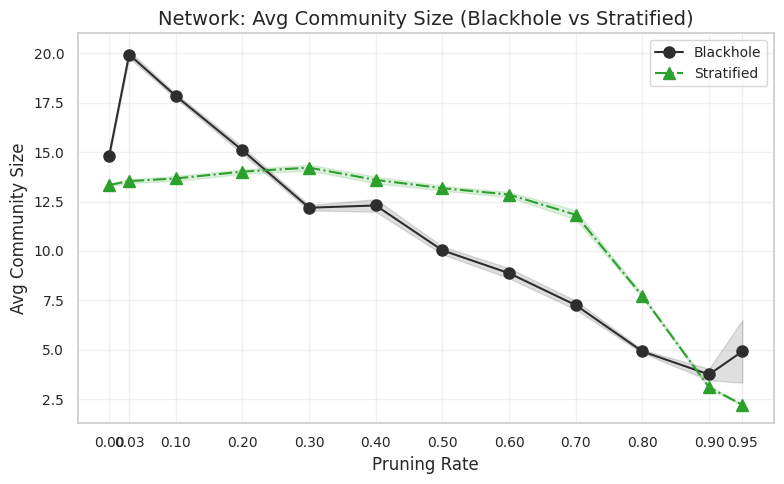

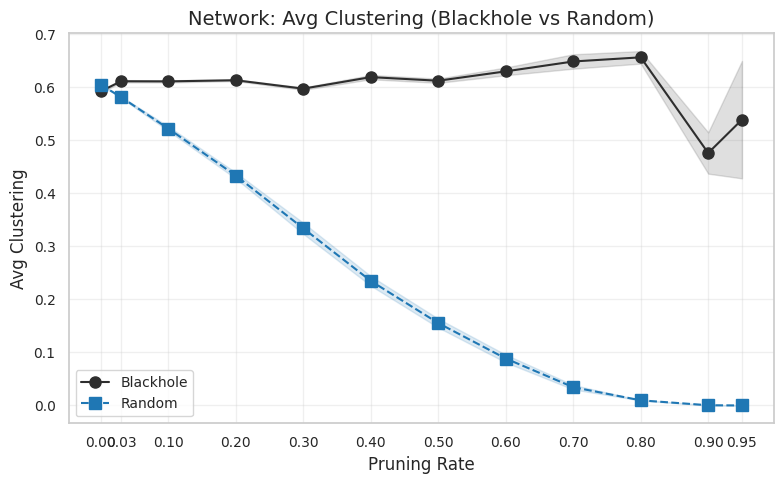

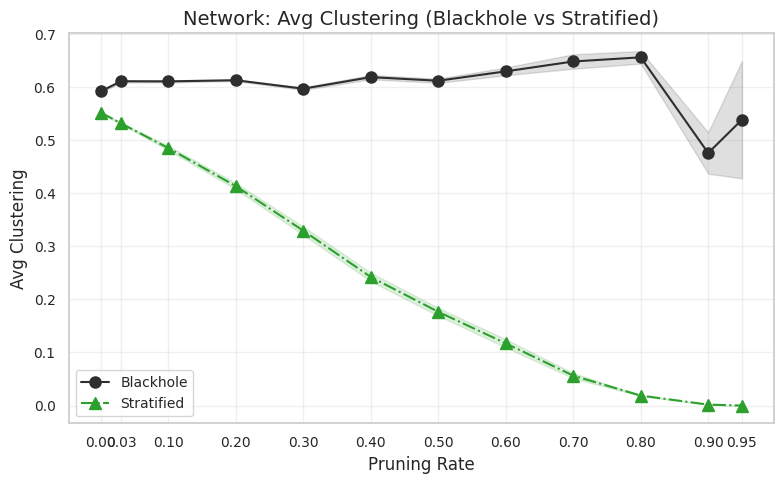

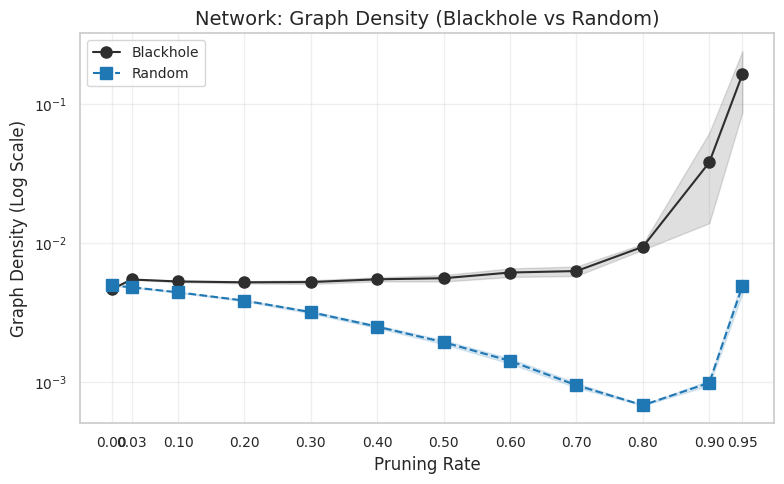

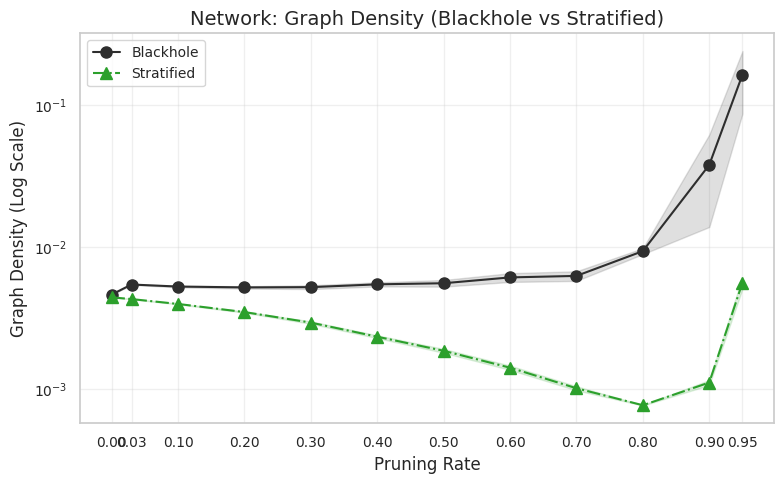

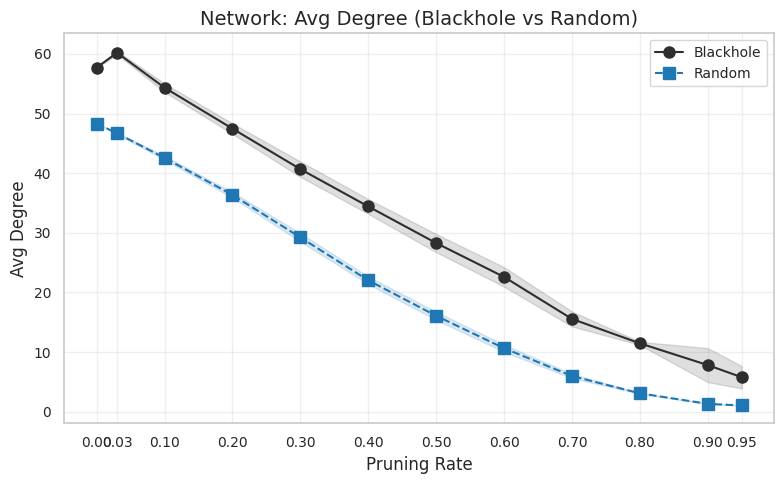

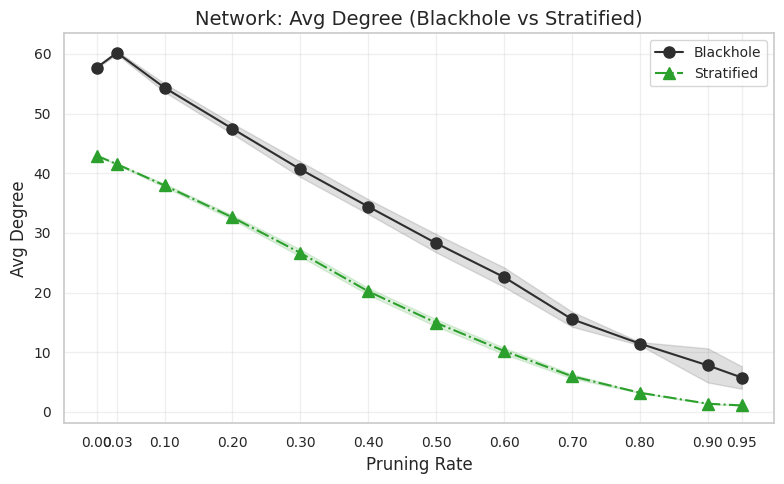

Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)
                     Accuracy_mean                     Accuracy_sem            \
Model                          GAT       GCN GraphSAGE          GAT       GCN   
Threshold Method                                                                
0.00      blackhole       0.632276  0.606623  0.621252     0.019801  0.005406   
          random          0.623554  0.636047  0.615361     0.033146  0.007119   
          stratified      0.628361  0.571482  0.590799     0.009908  0.040462   
0.03      blackhole       0.609334  0.590038  0.607137     0.022445  0.006509   
          random          0.610705  0.625630  0.606433     0.029775  0.006286   
          stratified      0.626805  0.587440  0.596962     0.020648  0.042499   
0.06      blackhole       0.617477  0.593562  0.606953     0.015280  0.011788   
          random          0.601141  0.628215  0.596032     0.029374  0.010291   
          stratified      0.627003  0.587355  0.593023

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid", context="notebook", palette="deep")

# Define consistent method colors, styles, and markers
method_colors = {
    'blackhole': '#2E2E2E',  # Dark gray for blackhole
    'random': '#1F77B4',     # Blue for random
    'stratified': '#2CA02C'  # Green for stratified
}
method_styles = {
    'blackhole': '-',
    'random': '--',
    'stratified': '-.'
}
method_markers = {
    'blackhole': 'o',
    'random': 's',
    'stratified': '^'
}

# Load data
df = pd.read_csv('model_results_with_error_bars.csv')

# Calculate SEM (assuming num_runs=1 as per main.py)
df['Accuracy_sem'] = df['Accuracy_std'] / np.sqrt(1)
df['Cohen_Kappa_sem'] = df['Cohen_Kappa_std'] / np.sqrt(1)

# Metrics and corresponding stds
performance_metrics = [
    ('Accuracy_mean', 'Accuracy_sem'),
    ('Cohen_Kappa_mean', 'Cohen_Kappa_sem')
]
network_metrics = [
    ('Modularity_mean', 'Modularity_std'),
    ('Num_Communities_mean', 'Num_Communities_std'),
    ('Avg_Community_Size_mean', 'Avg_Community_Size_std'),
    ('Avg_Clustering_mean', 'Avg_Clustering_std'),
    ('Graph_Density_mean', 'Graph_Density_std'),
    ('Avg_Degree_mean', 'Avg_Degree_std')
]

# Models and thresholds (excluding 0.06 as per original request)
models = df['Model'].unique()
threshold_values = sorted(df[df['Threshold'] != 0.06]['Threshold'].unique())

# Font sizes
label_fontsize = 12
tick_fontsize = 10
title_fontsize = 14
legend_fontsize = 10

# Function to check for significant outperformance
def is_significant(bh_mean, bh_sem, other_mean, other_sem):
    return bh_mean - bh_sem > other_mean + other_sem

# Plotting function for pairwise comparisons
def plot_pairwise_comparison(subset, metric, std_metric, title_prefix, methods, comparison_name):
    fig, ax = plt.subplots(figsize=(8, 5))
    ax2 = ax.twinx() if metric in ['Accuracy_mean', 'Cohen_Kappa_mean'] else None

    # Plot data for each method
    for method in methods:
        method_data = subset[subset['Method'] == method].sort_values('Threshold')
        ax.plot(method_data['Threshold'], method_data[metric],
                label=f'{method.title()}',
                color=method_colors[method], linestyle=method_styles[method],
                marker=method_markers[method], markersize=8)
        ax.fill_between(method_data['Threshold'],
                        method_data[metric] - method_data[std_metric],
                        method_data[metric] + method_data[std_metric],
                        alpha=0.15, color=method_colors[method])

    # Add Graph Density on secondary y-axis for Accuracy and Cohen's Kappa
    if metric in ['Accuracy_mean', 'Cohen_Kappa_mean']:
        density_data = subset[subset['Method'] == 'blackhole'].sort_values('Threshold')
        ax2.plot(density_data['Threshold'], density_data['Graph_Density_mean'],
                 color='purple', linestyle=':', label='Graph Density (BH)', alpha=0.7)
        ax2.set_yscale('log')
        ax2.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize, color='purple')
        ax2.tick_params(axis='y', labelsize=tick_fontsize, labelcolor='purple')

    # Annotations for significant outperformance (Accuracy only)
    if metric == 'Accuracy_mean':
        for thresh in threshold_values:
            bh_data = subset[(subset['Method'] == 'blackhole') & (subset['Threshold'] == thresh)]
            other_data = subset[(subset['Method'] == methods[1]) & (subset['Threshold'] == thresh)]
            if not (bh_data.empty or other_data.empty):
                bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
                other_acc, other_sem = other_data['Accuracy_mean'].values[0], other_data[std_metric].values[0]
                if is_significant(bh_acc, bh_sem, other_acc, other_sem):
                    ax.annotate('*', xy=(thresh, bh_acc), xytext=(0, 5),
                               textcoords='offset points', ha='center', color='red', fontsize=12)

    # Customize plot
    metric_name = metric.replace("_mean", "").replace("_", " ").title()
    ax.set_title(f'{title_prefix}: {metric_name} ({comparison_name})', fontsize=title_fontsize)
    ax.set_xlabel('Pruning Rate', fontsize=label_fontsize)
    ax.set_ylabel(metric_name, fontsize=label_fontsize)
    ax.set_xticks(threshold_values)
    ax.tick_params(axis='both', labelsize=tick_fontsize)
    ax.grid(True, alpha=0.3)

    # Adjust y-axis for Graph Density
    if metric == 'Graph_Density_mean':
        ax.set_yscale('log')
        ax.set_ylabel('Graph Density (Log Scale)', fontsize=label_fontsize)

    # Combine legends
    if ax2:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2, fontsize=legend_fontsize, loc='upper left')
    else:
        ax.legend(fontsize=legend_fontsize, loc='best')

    plt.tight_layout()
    plt.show()

# Generate plots for performance metrics (model-dependent)
for model in models:
    subset = df[(df['Model'] == model) & (df['Threshold'] != 0.06)]
    for metric, std_metric in performance_metrics:
        # Blackhole vs Random
        plot_pairwise_comparison(
            subset[subset['Method'].isin(['blackhole', 'random'])],
            metric, std_metric, model, ['blackhole', 'random'], 'Blackhole vs Random'
        )
        # Blackhole vs Stratified
        plot_pairwise_comparison(
            subset[subset['Method'].isin(['blackhole', 'stratified'])],
            metric, std_metric, model, ['blackhole', 'stratified'], 'Blackhole vs Stratified'
        )

# Generate plots for network metrics (model-independent, using GAT data)
subset = df[(df['Model'] == 'GAT') & (df['Threshold'] != 0.06)]
for metric, std_metric in network_metrics:
    # Blackhole vs Random
    plot_pairwise_comparison(
        subset[subset['Method'].isin(['blackhole', 'random'])],
        metric, std_metric, 'Network', ['blackhole', 'random'], 'Blackhole vs Random'
    )
    # Blackhole vs Stratified
    plot_pairwise_comparison(
        subset[subset['Method'].isin(['blackhole', 'stratified'])],
        metric, std_metric, 'Network', ['blackhole', 'stratified'], 'Blackhole vs Stratified'
    )

# Calculate maximum and minimum distances of BH Accuracy from Random and Stratified
distances_bh_random = []
distances_bh_stratified = []

for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc = bh_data['Accuracy_mean'].values[0]
            rand_acc = rand_data['Accuracy_mean'].values[0]
            strat_acc = strat_data['Accuracy_mean'].values[0]
            # Calculate distances
            dist_bh_random = bh_acc - rand_acc
            dist_bh_stratified = bh_acc - strat_acc
            distances_bh_random.append((dist_bh_random, thresh, model, bh_acc, rand_acc))
            distances_bh_stratified.append((dist_bh_stratified, thresh, model, bh_acc, strat_acc))

# Find maximum and minimum distances
max_dist_bh_random = max(distances_bh_random, key=lambda x: x[0])
min_dist_bh_random = min(distances_bh_random, key=lambda x: x[0])
max_dist_bh_stratified = max(distances_bh_stratified, key=lambda x: x[0])
min_dist_bh_stratified = min(distances_bh_stratified, key=lambda x: x[0])

# Summary Table for Performance Metrics
print("Summary Table: Accuracy and Cohen's Kappa (Mean ± SEM)")
summary_table = df.pivot_table(
    index=['Threshold', 'Method'],
    columns='Model',
    values=['Accuracy_mean', 'Accuracy_sem', 'Cohen_Kappa_mean', 'Cohen_Kappa_sem'],
    aggfunc='first'
)
print(summary_table)

# Summary Table for Network Metrics (using GAT data as representative)
print("\nSummary Table: Network Metrics (Mean ± Std)")
network_summary_table = df[df['Model'] == 'GAT'].pivot_table(
    index=['Threshold', 'Method'],
    values=[metric for metric, _ in network_metrics],
    aggfunc='first'
)
print(network_summary_table)

# Key Findings
print("\nKey Findings:")
# Significant outperformance
bh_outperform = []
for thresh in threshold_values:
    for model in models:
        bh_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'blackhole') & (df['Model'] == model)]
        rand_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'random') & (df['Model'] == model)]
        strat_data = df[(df['Threshold'] == thresh) & (df['Method'] == 'stratified') & (df['Model'] == model)]
        if not (bh_data.empty or rand_data.empty or strat_data.empty):
            bh_acc, bh_sem = bh_data['Accuracy_mean'].values[0], bh_data['Accuracy_sem'].values[0]
            rand_acc, rand_sem = rand_data['Accuracy_mean'].values[0], rand_data['Accuracy_sem'].values[0]
            strat_acc, strat_sem = strat_data['Accuracy_mean'].values[0], strat_data['Accuracy_sem'].values[0]
            if is_significant(bh_acc, bh_sem, rand_acc, rand_sem) and \
               is_significant(bh_acc, bh_sem, strat_acc, strat_sem):
                bh_outperform.append((thresh, model, bh_acc, rand_acc, strat_acc))

if bh_outperform:
    print("Thresholds where Blackhole significantly outperforms both Random and Stratified (Accuracy):")
    for thresh, model, bh_acc, rand_acc, strat_acc in bh_outperform:
        print(f"- Threshold {thresh:.2f}, Model {model}: BH Accuracy = {bh_acc:.4f}, "
              f"Random = {rand_acc:.4f}, Stratified = {strat_acc:.4f}")
else:
    print("- No thresholds where Blackhole significantly outperforms both Random and Stratified.")

# Maximum and Minimum Distances
print("\nMaximum and Minimum Distances of Blackhole Accuracy from Random and Stratified:")
print("Blackhole vs Random:")
print(f"- Maximum Distance: {max_dist_bh_random[0]:.4f} at Threshold {max_dist_bh_random[1]:.2f}, Model {max_dist_bh_random[2]} "
      f"(BH Accuracy = {max_dist_bh_random[3]:.4f}, Random Accuracy = {max_dist_bh_random[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_random[0]:.4f} at Threshold {min_dist_bh_random[1]:.2f}, Model {min_dist_bh_random[2]} "
      f"(BH Accuracy = {min_dist_bh_random[3]:.4f}, Random Accuracy = {min_dist_bh_random[4]:.4f})")
print("Blackhole vs Stratified:")
print(f"- Maximum Distance: {max_dist_bh_stratified[0]:.4f} at Threshold {max_dist_bh_stratified[1]:.2f}, Model {max_dist_bh_stratified[2]} "
      f"(BH Accuracy = {max_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {max_dist_bh_stratified[4]:.4f})")
print(f"- Minimum Distance: {min_dist_bh_stratified[0]:.4f} at Threshold {min_dist_bh_stratified[1]:.2f}, Model {min_dist_bh_stratified[2]} "
      f"(BH Accuracy = {min_dist_bh_stratified[3]:.4f}, Stratified Accuracy = {min_dist_bh_stratified[4]:.4f})")

# Highlight highest accuracy
max_acc_row = df.loc[df['Accuracy_mean'].idxmax()]
print(f"\nHighest Accuracy: {max_acc_row['Accuracy_mean']:.4f} by {max_acc_row['Model']} "
      f"({max_acc_row['Method']}) at Threshold {max_acc_row['Threshold']:.2f}, "
      f"with Graph Density = {max_acc_row['Graph_Density_mean']:.6f}")